In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pickle
import torch
from torch import nn
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
print(torch.__version__)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

2.3.0+cu121
Using cpu device


__Getting data__

In [94]:
stock = "RR.L.csv"
train = pd.read_csv("../data/train/" + stock).set_index("Date")
validation = pd.read_csv("../data/validation/" + stock).set_index("Date")
test = pd.read_csv("../data/test/" + stock).set_index("Date")
train = pd.concat([train, validation], axis = 0)
train

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1988-07-01,0.244081,0.240647,0.249138,0.244657,0.105673,0.000000
1988-07-04,0.246383,0.242929,0.251463,0.246940,0.106718,0.000000
1988-07-05,0.260199,0.256619,0.265413,0.260639,0.112991,0.000000
1988-07-06,0.260199,0.256619,0.265413,0.260639,0.112991,0.000000
1988-07-07,0.264804,0.261183,0.270063,0.265205,0.115081,0.000000
...,...,...,...,...,...,...
2022-11-29,0.156845,0.157395,0.159766,0.158655,0.176184,0.007171
2022-11-30,0.160471,0.161390,0.163680,0.162912,0.180353,0.018421
2022-12-01,0.163620,0.161390,0.154647,0.153474,0.171112,0.015249


__Date Embedding and cyclical transformation__

In [95]:

def getDateRange(start_date, end_date):
    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return dates

# Define the date range
start_date = datetime(2024, 5, 24) - timedelta(days=40*365)  # 40 years ago
end_date = datetime(2024, 5, 24) + timedelta(days=40*365)    # 40 years in the future

# Generate the list of dates
dictionary = getDateRange(start_date, end_date)
date_to_index = {date: index for index, date in enumerate(dictionary)}

class DateEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings = 29201, embedding_dim = 8):
        super(DateEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, dates):
        date_indices = torch.tensor([date_to_index[date] for date in dates], dtype=torch.long)
        embedded_dates = self.embedding(date_indices)
        return embedded_dates

In [96]:
def dateCyclicalTransformation(date):
    date = pd.to_datetime(date)

    monthSin = np.sin(2 * np.pi * date.month/12.0)
    monthCos = np.cos(2 * np.pi * date.month/12.0)
    daySin = np.sin(2 * np.pi * date.day/31.0)
    dayCos = np.cos(2 * np.pi * date.day/31.0)

    return [monthSin, monthCos, daySin, dayCos]

In [97]:
date = train.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)
train = train.join(date)

date = validation.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)
validation = validation.join(date)

date = test.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)
test = test.join(date)

__Creating data loader__

In [98]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

xTrain, yTrain = createSequence(train, train["Close"], 30, 30)
xValid, yValid = createSequence(validation, validation["Close"], 30, 30)
xTest, yTest = createSequence(test, test["Close"], 30, 30)

__Model__

In [99]:
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
xValidation = np.array(xValid)
yValidation = np.array(yValid)
xTest = np.array(xTest)
yTest = np.array(yTest)

num_samples, num_days, num_features = xTrain.shape
xTrain_flattened = xTrain.reshape(num_samples, num_days * num_features)

num_samples, num_days, num_features = xValidation.shape
xValidation_flattened = xValidation.reshape(num_samples, num_days * num_features)

num_samples, num_days, num_features = xTest.shape
xTest_flattened = xTest.reshape(num_samples, num_days * num_features)

In [100]:
svr = SVR(kernel='rbf', degree=3, C=1.0, epsilon=0.01, max_iter=-1)
svrMultiOutput = MultiOutputRegressor(svr)
#svrMultiOutput.fit(xTrain_flattened, yTrain)
#pickle.dump(svrMultiOutput, open("../models/svr_params.pickle", "wb"))

# Load the parameters from file
svrMultiOutput = pickle.load(open("../models/svr_params.pickle", "rb"))


MultiOutputRegressor(estimator=SVR(epsilon=0.01))

In [102]:
# Make predictions
y_pred = svrMultiOutput.predict(xTest_flattened)

# Print the shape of predictions to verify
print(y_pred.shape)  # Should be (num_samples, 30)

(309, 30)


In [104]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTest, y_pred)
print(f'Total Mean Squared Error: {mse_total}')

mae_total = mean_absolute_error(yTest, y_pred)
print(f'Total Mean Absolute Error: {mae_total}')

Total Mean Squared Error: 0.00561949131884506
Total Mean Absolute Error: 0.05280230599676412


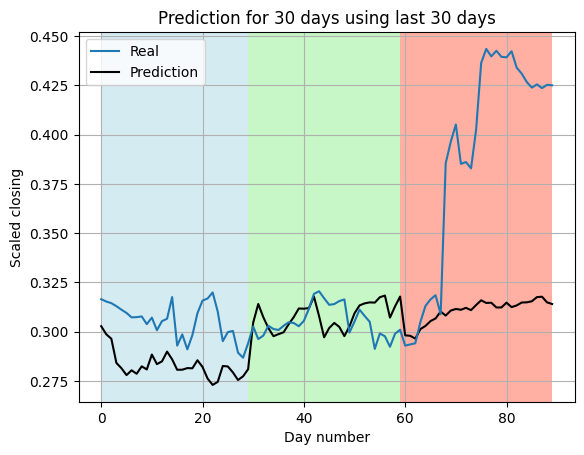

In [138]:
set = 30*3
real = np.concatenate([yTest[set-30], yTest[set], yTest[set + 30]])
predictions = np.concatenate([y_pred[set-30], y_pred[set], y_pred[set + 30]])

fig, ax = plt.subplots()
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)
ax.legend(["Real", "Prediction"])
ax.axvspan(0, 29, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
ax.axvspan(29, 59, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
ax.axvspan(59, 89, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 30 days using last 30 days")
plt.show()